In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg

from livecell_tracker.segment.detectron_utils import (
    segment_detectron_wrapper,
    segment_images_by_detectron,
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)


dataset_dir_path = Path(
    "../datasets/test_data_STAV-A549/DIC_data"
)

mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")

In [2]:
mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
mask_dataset.time2url

3 png img file paths loaded: 


{0: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif.png',
 1: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif.png',
 2: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif.png'}

In [3]:
dic_dataset = LiveCellImageDataset(dataset_dir_path, ext="tif")

3 tif img file paths loaded: 


In [4]:
dic_dataset.time2url

{0: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif',
 1: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif',
 2: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif'}

Convert label masks to single objects

In [5]:
from skimage.measure import regionprops

single_cells = []

for time in mask_dataset.time2url:
    img = dic_dataset.get_img_by_time(time)
    seg_mask = mask_dataset.get_img_by_time(time)
    props_list = regionprops(seg_mask)
    for prop in props_list:
        single_cells.append(
            SingleCellStatic(
                timeframe=time,
                img_dataset = dic_dataset,
                mask_dataset = mask_dataset,
                bbox=prop.bbox,
                contour=prop.coords, # TODO: fix BUG here... should not be coords but contour
            )
        )


In [6]:
# for testing
# single_cells = single_cells[:10]

In [7]:
len(single_cells)

42

In [8]:
single_cells_by_time = {}
for cell in single_cells:
    if cell.timeframe not in single_cells_by_time:
        single_cells_by_time[cell.timeframe] = []
    single_cells_by_time[cell.timeframe].append(cell)

In [9]:
for time in single_cells_by_time:
    print(time, len(single_cells_by_time[time]))

0 13
1 14
2 15


Visualize one single cell

<AxesSubplot: >

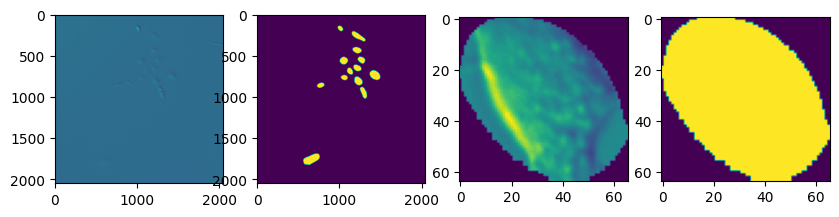

In [10]:
sc = single_cells[0]

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
sc.show(ax=axes[0])
sc.show_mask(ax=axes[1])
sc.show_contour_img(ax=axes[2])
sc.show_contour_mask(ax=axes[3])

Calculate overlap between two single cells

<AxesSubplot: >

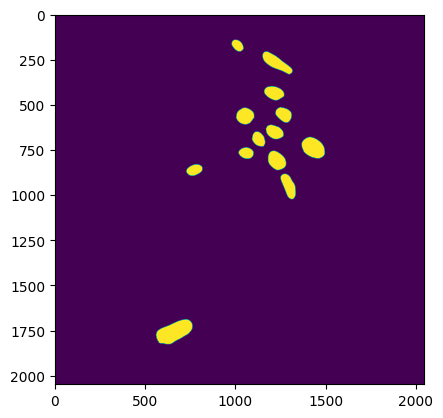

In [11]:
sc.show_mask(padding=200)

<AxesSubplot: >

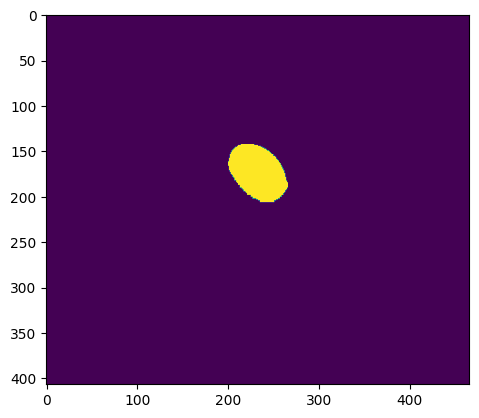

In [12]:
sc.show_contour_mask(padding=200)

In [13]:
sc1 = single_cells_by_time[0][0]
sc2 = single_cells_by_time[0][1]

def compute_overlap_bf(sc1, sc2):
    # calculate overlap
    img_shape = sc1.get_img().shape
    # TODO: add a helper function in single_cell to returna mask with only the current cell in it.
    mask1 = sc1.get_contour_mask(padding=np.max(img_shape)).astype(bool)
    mask2 = sc2.get_contour_mask(padding=np.max(img_shape)).astype(bool)

    overlap_area = np.logical_and(mask1, mask2).sum()
    iou = overlap_area / (mask1 | mask2).sum()
    return overlap_area, iou

def bbox_overlap(bbox1, bbox2):
    # calculate overlap
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2
    x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
    y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    overlap_area = x_overlap * y_overlap
    bbox1_area = (x1_max - x1_min) * (y1_max - y1_min)
    bbox2_area = (x2_max - x2_min) * (y2_max - y2_min)
    iou = overlap_area / (bbox1_area + bbox2_area - overlap_area)
    return overlap_area, iou

def compute_overlap(sc1: SingleCellStatic, sc2: SingleCellStatic):
    bbox1, bbox2 = sc1.get_bbox(), sc2.get_bbox()
    bbox_overlap_area, bbox_iou = bbox_overlap(bbox1, bbox2)
    if bbox_iou <= 0:
        return 0, 0

    merged_bbox = (min(bbox1[0], bbox2[0]), min(bbox1[1], bbox2[1]), max(bbox1[2], bbox2[2]), max(bbox1[3], bbox2[3]))
    # calculate overlap
    # TODO: add a helper function in single_cell to returna mask with only the current cell in it.
    mask1 = sc1.get_contour_mask(crop=False)[merged_bbox[0]:merged_bbox[2], merged_bbox[1]:merged_bbox[3]]
    mask2 = sc2.get_contour_mask(crop=False)[merged_bbox[0]:merged_bbox[2], merged_bbox[1]:merged_bbox[3]]
    overlap_area = np.logical_and(mask1, mask2).sum()
    iou = overlap_area / (mask1 | mask2).sum()
    return overlap_area, iou
t1, t2 = 0, 1

In [14]:
def test_compute_overlap():
    for sc in single_cells:
        for sc_tmp in single_cells:
            # compare two overlap algorithms
            overlap_area, iou = compute_overlap(sc, sc_tmp)
            overlap_area_bf, iou_bf = compute_overlap_bf(sc, sc_tmp)
            # print(overlap_area, overlap_area_bf)
            assert overlap_area == overlap_area_bf
            assert iou == iou_bf
# test_compute_overlap()

In [15]:
import tqdm
def compute_overlaps(sc_list1, sc_list2):
    overlap_map = {}
    for sc1 in tqdm.tqdm(sc_list1, desc="Computing overlaps"):
        for sc2 in sc_list2:
            overlap_area, iou = compute_overlap(sc1, sc2)
            overlap_map[(sc1, sc2)] = (overlap_area, iou)
    # parallel version
    return overlap_map

overlap_map_by_time = {}
times = set(sorted(list(single_cells_by_time.keys())))
for time in times:
    if time + 1 not in times:
        print(f"Time {time} is the last time point, skipping")
        continue
    overlap_map_by_time[time] = compute_overlaps(single_cells_by_time[time], single_cells_by_time[time + 1])

Computing overlaps: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]

Time 2 is the last time point, skipping


In [16]:
sc1, sc2 = single_cells_by_time[0][0], single_cells_by_time[1][0]
overlap_map_by_time[0][(sc1, sc2)]

(2745, 0.8733693923003499)

In [17]:
len(single_cells_by_time[2])

15

Check the cells visually

0 1 (2745, 0.8733693923003499)


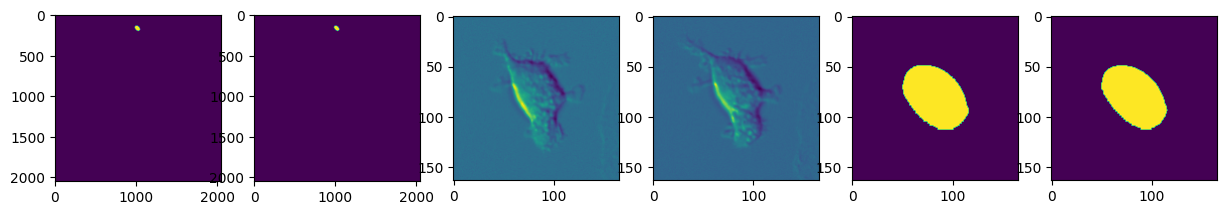

0 1 (7399, 0.7861240968975776)


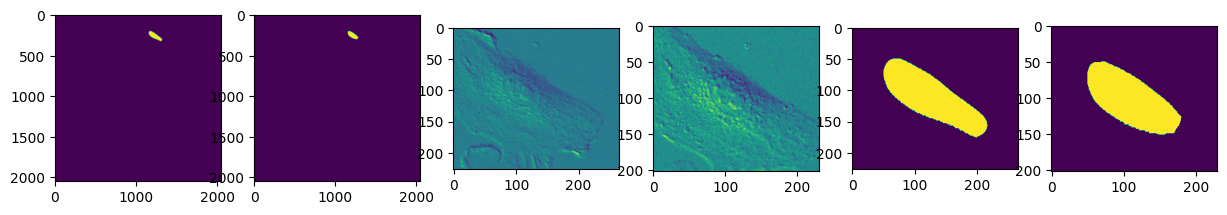

0 1 (1477, 0.14705296694544007)


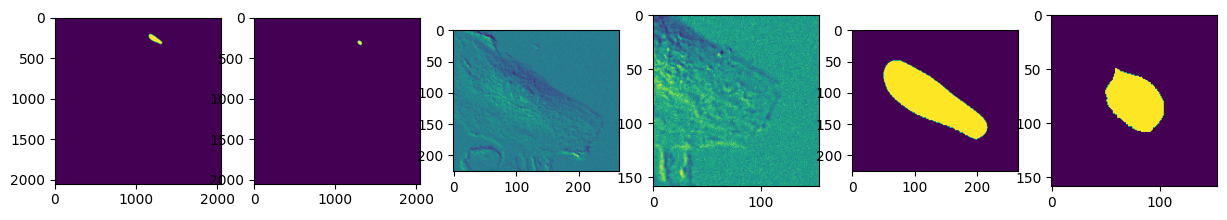

0 1 (6089, 0.8647919329640676)


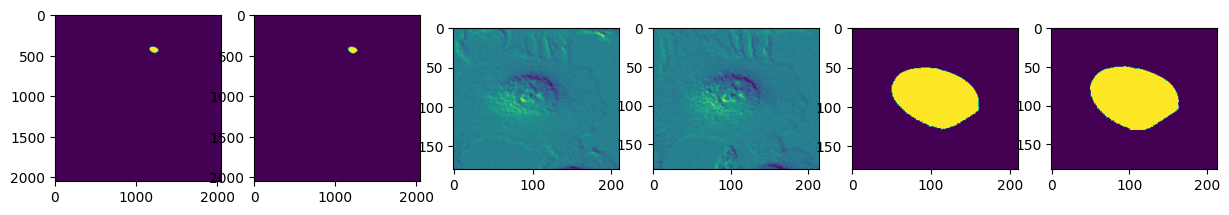

0 1 (5295, 0.926509186351706)


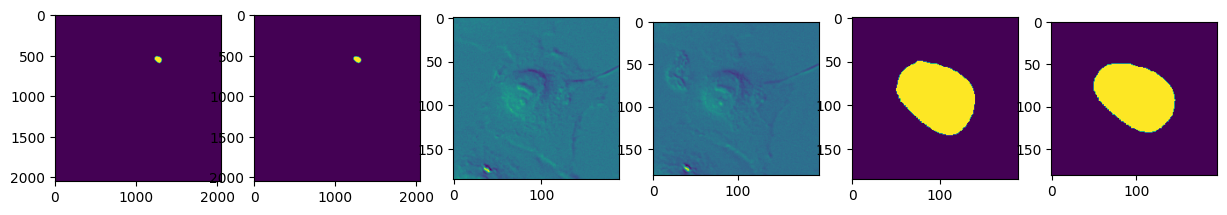

0 1 (6418, 0.8590550127158345)


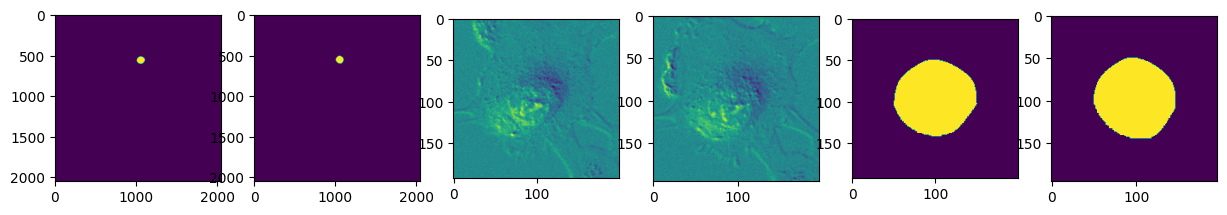

0 1 (5584, 0.9679320506153579)


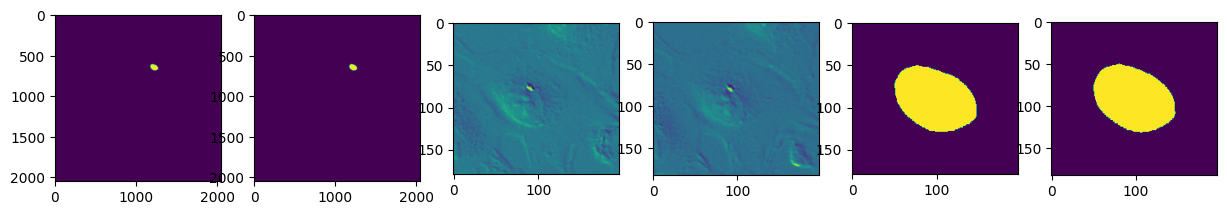

0 1 (4263, 0.9439769707705934)


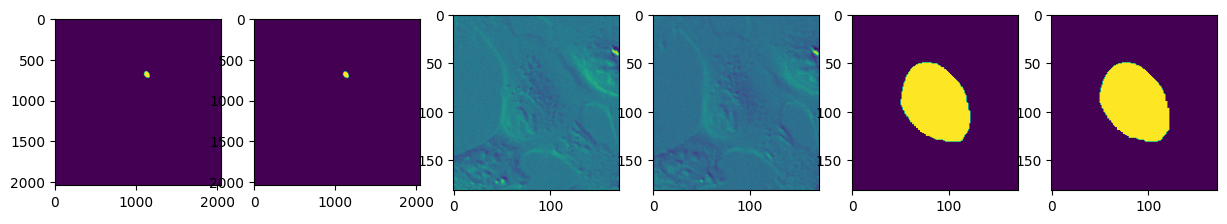

0 1 (11135, 0.88457260883381)


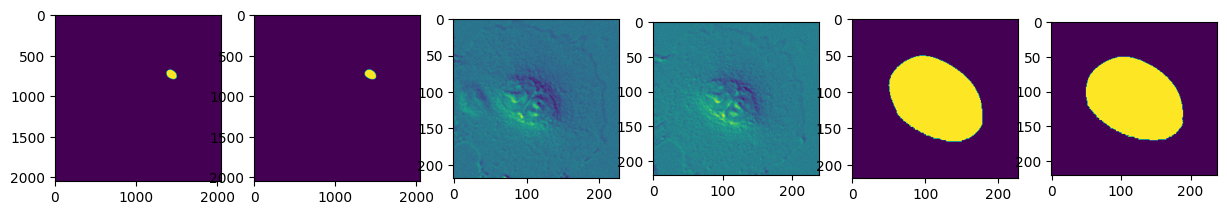

0 1 (3682, 0.7356643356643356)


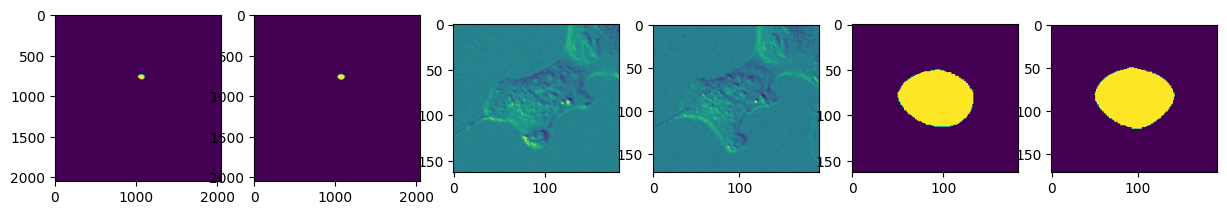

0 1 (7585, 0.9445828144458281)


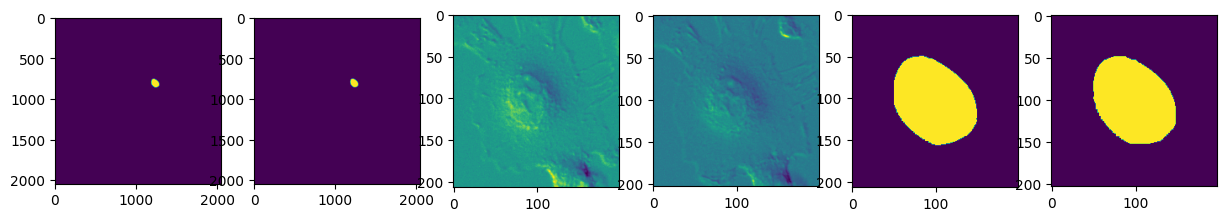

0 1 (2358, 0.5717749757516973)


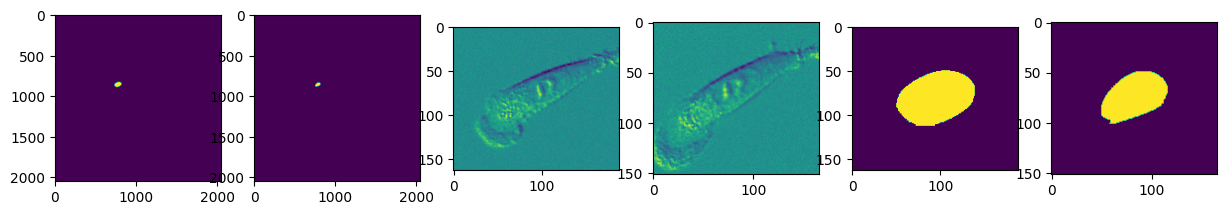

0 1 (6577, 0.8142874829763526)


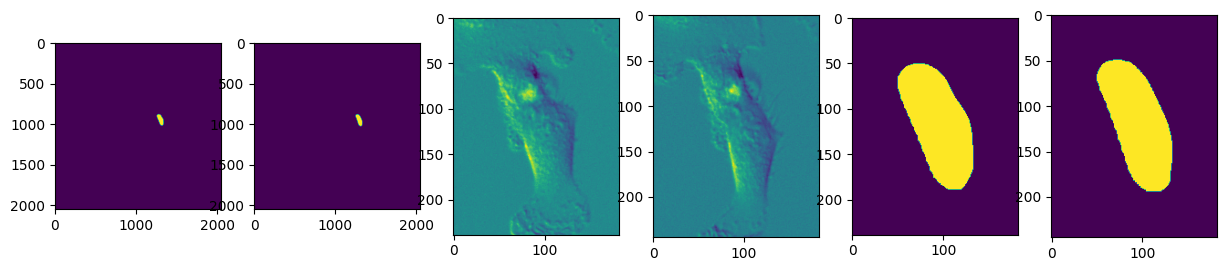

0 1 (16687, 0.9067543335325762)


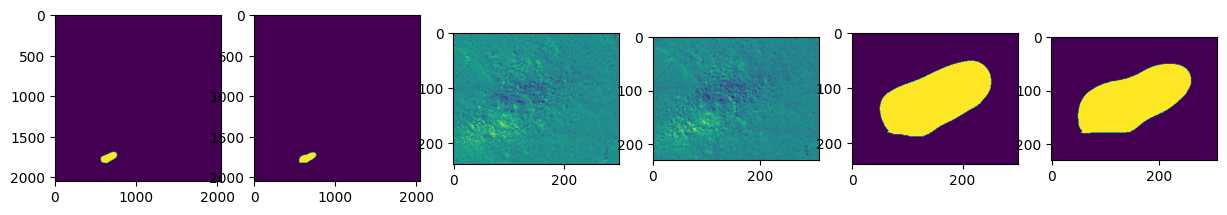

1 2 (2833, 0.8956686689851406)


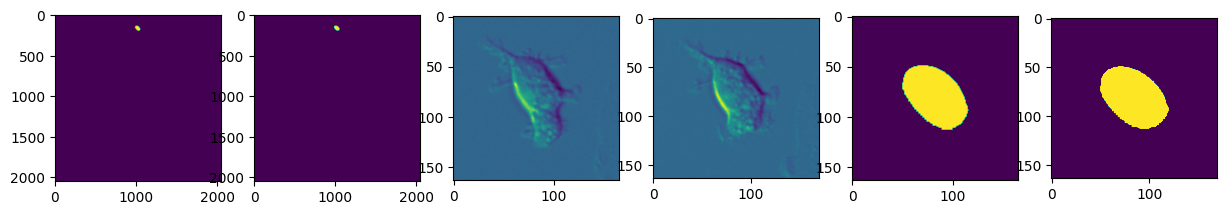

1 2 (7066, 0.7989597467209407)


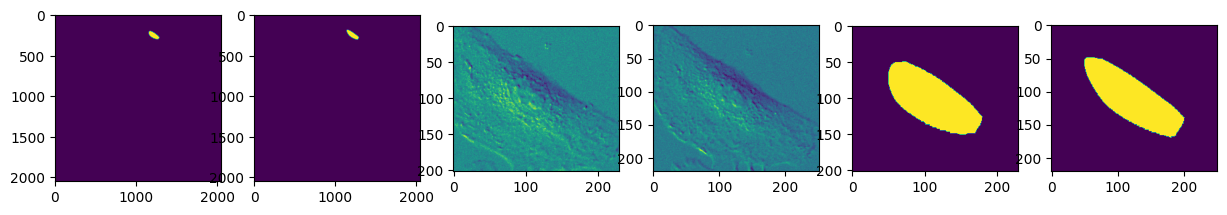

1 2 (162, 0.01549053356282272)


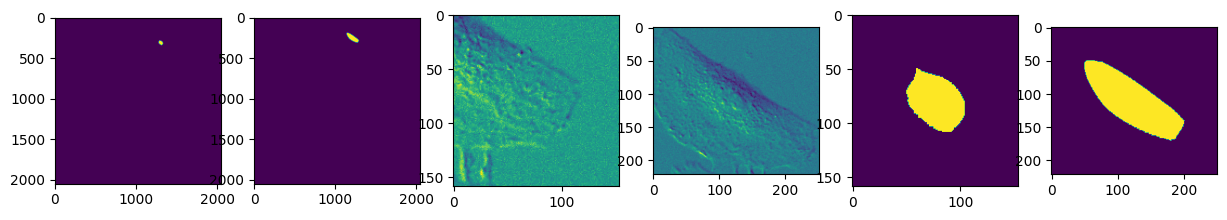

1 2 (1861, 0.8513266239707228)


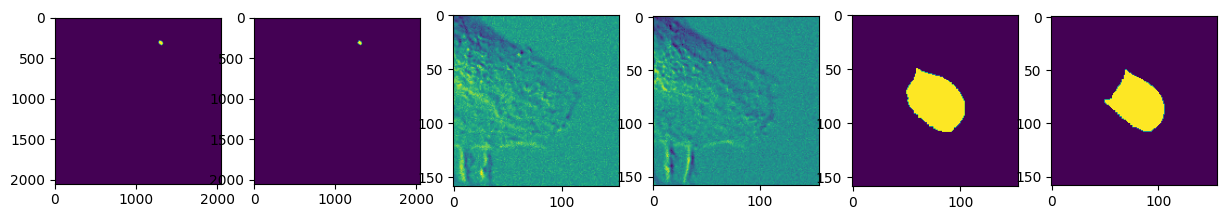

1 2 (6826, 0.9345564074479737)


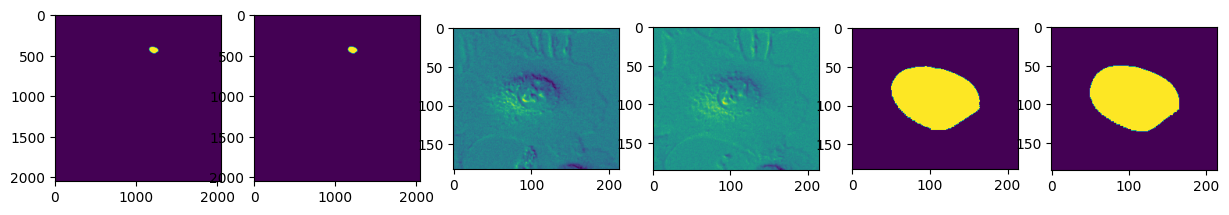

1 2 (6608, 0.8516561412553164)


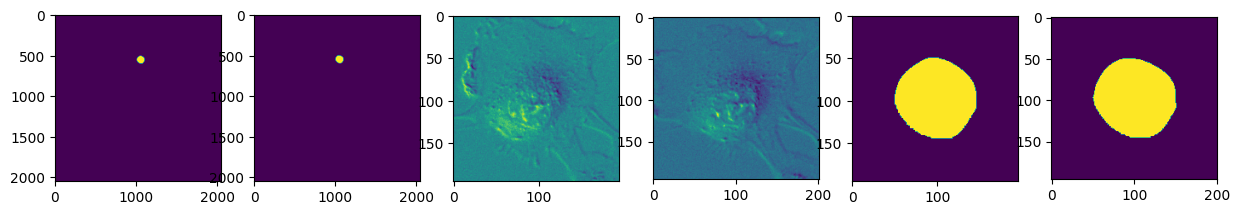

1 2 (5591, 0.8554161566707467)


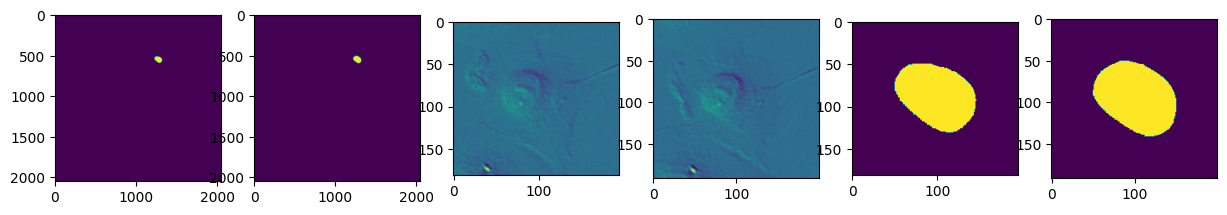

1 2 (5424, 0.8998009289980093)


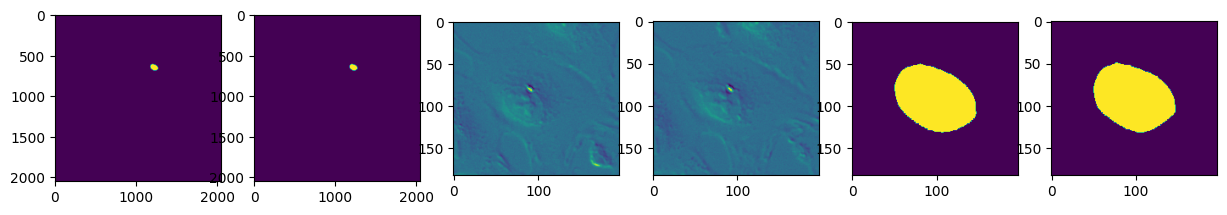

1 2 (4109, 0.9210939251288949)


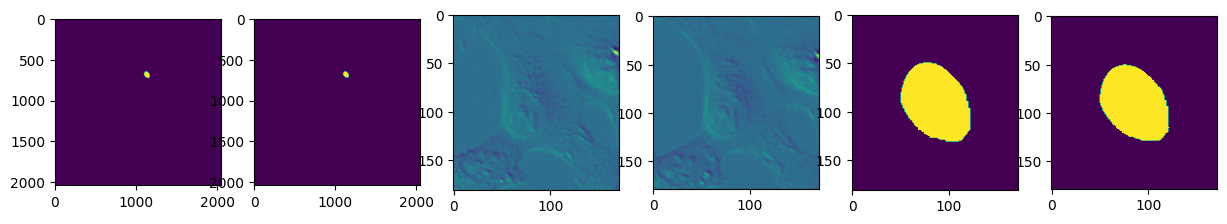

1 2 (12563, 0.9555792195938236)


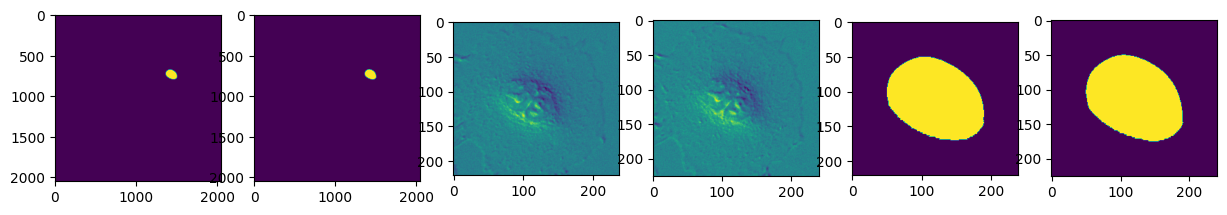

1 2 (4308, 0.8303777949113339)


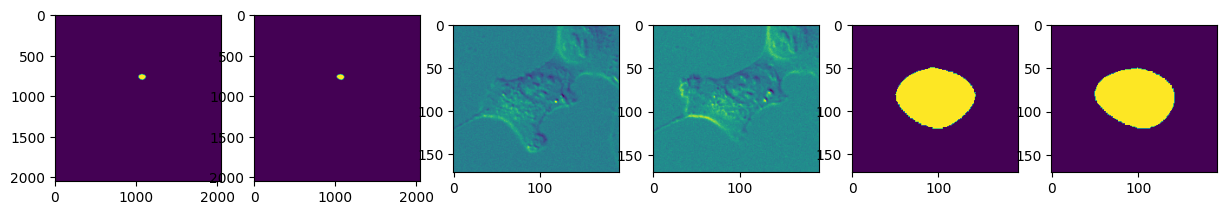

1 2 (7585, 0.9234234234234234)


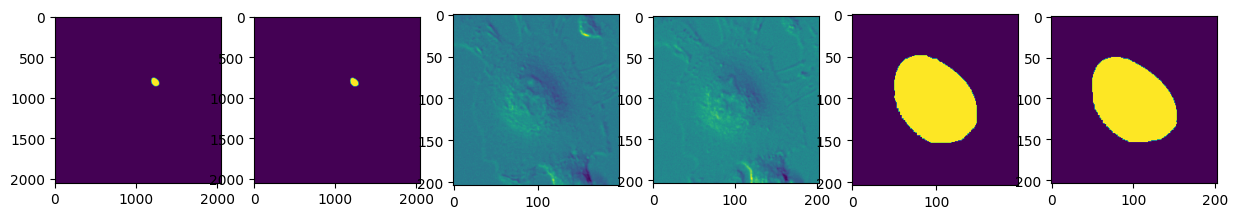

1 2 (2362, 0.4573088092933204)


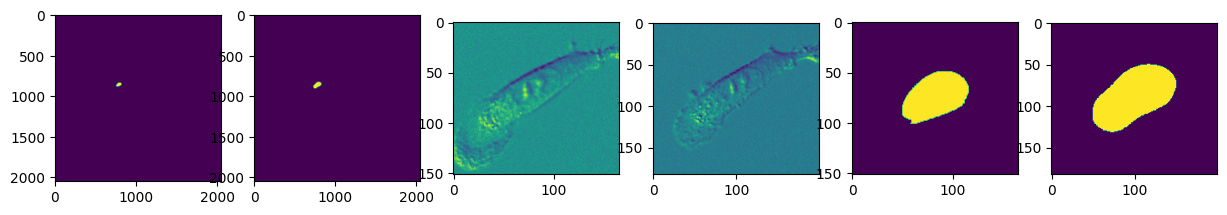

1 2 (3116, 0.40822743351238044)


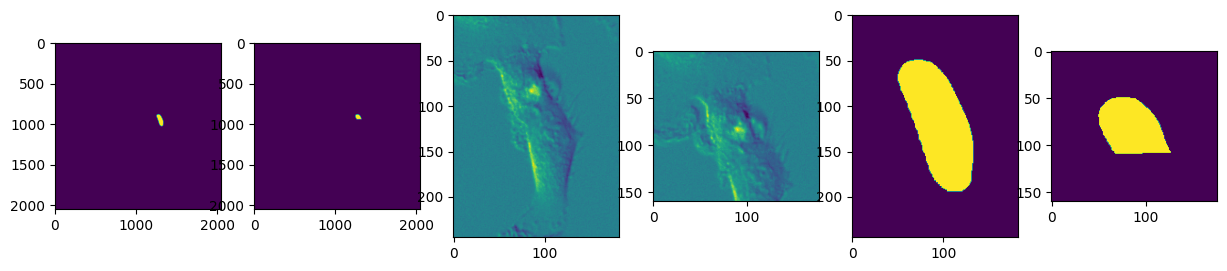

1 2 (4039, 0.537315418384994)


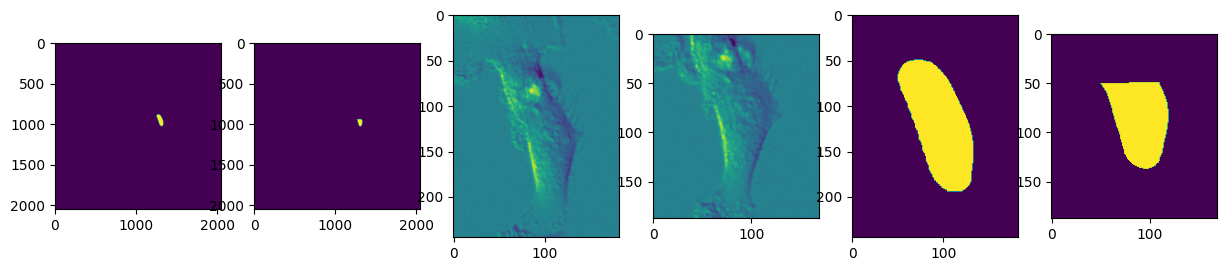

1 2 (16868, 0.7351172317615271)


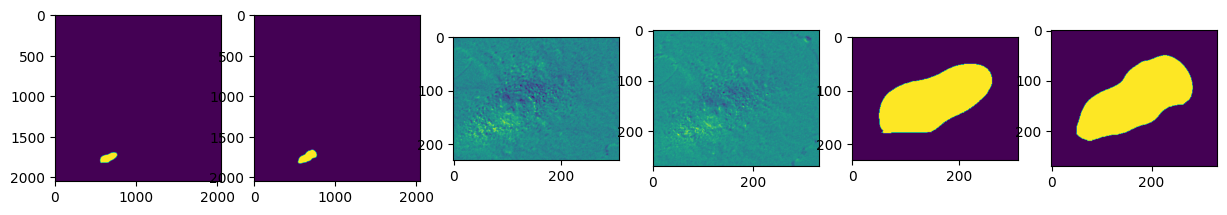

In [18]:
for time in overlap_map_by_time:
    overlap_map = overlap_map_by_time[time]
    for sc_tmp1, sc_tmp2 in overlap_map:
        if sc_tmp1 == sc_tmp2:
            continue
        if overlap_map[(sc_tmp1, sc_tmp2)][0] > 0:
            print(sc_tmp1.timeframe, sc_tmp2.timeframe, overlap_map[(sc_tmp1, sc_tmp2)])
            fig, axes = plt.subplots(1, 6, figsize=(15, 5))
            padding=50
            sc_tmp1.show_contour_mask(crop=False, ax = axes[0])
            sc_tmp2.show_contour_mask(crop=False, ax = axes[1])
            sc_tmp1.show(crop=True, ax = axes[2], padding=padding)
            sc_tmp2.show(crop=True, ax = axes[3], padding=padding)
            sc_tmp1.show_contour_mask(crop=True, ax = axes[4], padding=padding)
            sc_tmp2.show_contour_mask(crop=True, ax = axes[5], padding=padding)
            plt.show()


In [19]:
np.unique(sc1.mask_dataset.get_img_by_time(0))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32)

In [20]:
np.unique(sc1.mask_dataset.get_img_by_time(1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int32)

```
sc.datasets["img"]
sc.datasets["mask"]
sc.datasets["label"]
sc.datasets["TRITC"]
```

In [24]:
from livecell_tracker.segment.utils import match_mask_labels_by_iou
def match_mask_labels_by_iou(seg_label_mask, gt_label_mask, bg_label=0, return_all=False):
    """compute the similarity between ground truth mask and segmentation mask by intersection over union

    Parameters
    ----------
    seg_label_mask : _type_
        _description_
    gt_label_mask : _type_
        _description_
    bg_label : int, optional
        _description_, by default 0
    return_all : bool, optional
        _description_, by default False
    Returns
    -------
        A <gt2seg_map>, mapping ground truth keys to a dictionary of the best matching segmentation label and its iou
    """
    gt2seg_map = {}
    all_gt2seg_iou__map = {}
    # gets all the unique labels in the labeled_seg_mask and gtly_curated_mask
    seg_labels = np.unique(seg_label_mask)
    gt_labels = np.unique(gt_label_mask)

    temp_seg_mask = seg_label_mask.copy()
    temp_gt_mask = gt_label_mask.copy()

    for gt_label in gt_labels:
        if gt_label == bg_label:
            continue
        gt_label_key = gt_label
        all_gt2seg_iou__map[gt_label_key] = []
        gt2seg_map[gt_label_key] = {}
        temp_gt_mask = gt_label_mask.copy()
        # isolates the current cell in the temp gtly_curated_mask and gets its pixels to 1
        temp_gt_mask[temp_gt_mask != gt_label] = 0
        temp_gt_mask[temp_gt_mask != 0] = 1

        best_iou = 0
        for seg_label in seg_labels:
            if seg_label == bg_label:
                continue
            temp_seg_mask = seg_label_mask.copy()

            # isolate the current cell in the temp_seg_mask and set its pixels to 1
            temp_seg_mask[temp_seg_mask != seg_label] = 0
            temp_seg_mask[temp_seg_mask != 0] = 1

            matching_rows, matching_columns = np.where(temp_seg_mask == 1)
            intersection_area = (temp_gt_mask[matching_rows, matching_columns] == 1).sum()
            union_area = temp_gt_mask.sum() + temp_seg_mask.sum() - intersection_area
            iou = intersection_area / union_area
            io_gt = intersection_area / temp_gt_mask.sum()
            io_seg = intersection_area / temp_seg_mask.sum()
            all_gt2seg_iou__map[gt_label_key].append({
                "seg_label": seg_label,
                "iou": iou,
                "io_gt": io_gt,
                "io_seg": io_seg,
            })

            if iou > best_iou:
                best_iou = iou
                gt2seg_map[gt_label_key]["best_iou"] = iou
                gt2seg_map[gt_label_key]["seg_label"] = seg_label
    if return_all:
        return gt2seg_map, all_gt2seg_iou__map
    else:
        return gt2seg_map
    
match_mask_labels_by_iou(sc1.mask_dataset.get_img_by_time(2), sc1.mask_dataset.get_img_by_time(1), return_all=True)

({1: {'best_iou': 0.8956686689851406, 'seg_label': 1},
  2: {'best_iou': 0.7981454257604885, 'seg_label': 2},
  3: {'best_iou': 0.8513266239707228, 'seg_label': 3},
  4: {'best_iou': 0.9344194961664841, 'seg_label': 4},
  5: {'best_iou': 0.8516561412553164, 'seg_label': 5},
  6: {'best_iou': 0.8555470543228768, 'seg_label': 6},
  7: {'best_iou': 0.8998009289980093, 'seg_label': 7},
  8: {'best_iou': 0.9210939251288949, 'seg_label': 8},
  9: {'best_iou': 0.9554270936335285, 'seg_label': 9},
  10: {'best_iou': 0.8301850424055512, 'seg_label': 10},
  11: {'best_iou': 0.9235358577864361, 'seg_label': 11},
  12: {'best_iou': 0.4573088092933204, 'seg_label': 12},
  13: {'best_iou': 0.537315418384994, 'seg_label': 14},
  14: {'best_iou': 0.7343014128728415, 'seg_label': 15}},
 {1: [{'seg_label': 1,
    'iou': 0.8956686689851406,
    'io_gt': 0.9840222299409517,
    'io_seg': 0.9088867500802054},
   {'seg_label': 2, 'iou': 0.0, 'io_gt': 0.0, 'io_seg': 0.0},
   {'seg_label': 3, 'iou': 0.0, 'io_